<a href="https://colab.research.google.com/github/nicolashernandez/teaching_nlp/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environnement

Le notebook est construit pour fonctionner sur cpu.

In [72]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial

## tqdm for loading bars
from tqdm.notebook import tqdm

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Setting the seed
# https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import math
import copy

# Set the device to load tensors and perform the NN computation
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cpu


<ipython-input-72-704e5da40505>:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

 # Introduction


## Votre travail

Ce notebook a pour objectif de vous faire prendre en main l'architecture neuronale Transformer. Tour à tour vous aurez à coder ou intervenir sur le code des modules suivants :
- `scaled_dot_product_attention`
- `eedForward`
-  scaled_dot_product_attention

##  Attention is all you need

L'illustration suivante est extraite de [Vaswani, Ashish; Shazeer, Noam; Parmar, Niki; Uszkoreit, Jakob; Jones, Llion; Gomez, Aidan N; Kaiser, Łukasz; Polosukhin, Illia (2017). "Attention is All you Need". Advances in Neural Information Processing Systems. 30. Curran Associates, Inc.](https://arxiv.org/pdf/1706.03762)
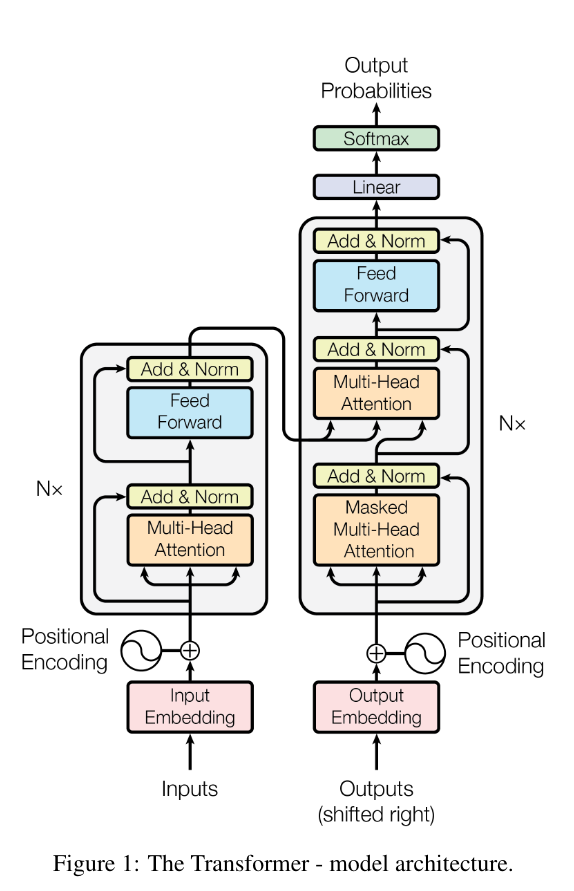

## PyTorch Transformer

PyTorch propose une [implémentation de l'architecture Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) fondée sur le papier "Attention Is All You Need" de (Vaswani et al, NIPS'2017) ; [ici pour un aperçu du code source](https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html#Transformer).

Il s'agit de la classe [`torch.nn.Transformer`](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) qui permet entre autres de spécifier les paramètres suivants d'un modèle instancié :
* `dim_model` (int) – the number of expected features in the encoder/decoder inputs ; il s'agit de la *taille du modèle* i.e. la *dimension des embeddings* (default=512).
* `num_head` (int) – the number of heads in the multiheadattention models (default=8).
* `num_encoder_layers` (int) – the number of sub-encoder-layers in the encoder (default=6).
* `num_decoder_layers` (int) – the number of sub-decoder-layers in the decoder (default=6).
* `dim_feedforward` (int) – the dimension of the feedforward network model (default=2048).
* `dropout` (float) – the dropout value (default=0.1).
* `activation`  – the activation function of encoder/decoder intermediate layer, can be a string (“relu” or “gelu”) or a unary callable. Default: relu

Comme tous modèles de réseaux de neurones, la classe hérite de [`torch.nn.Modules`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). Elle implémente donc la méthode `forward` qui spécifie le traitement qui est réalisé quand l'instance est appelée.

Parmi les paramètres, on note notamment :

* `src` (Tensor) – the input sequence to the encoder (required).

* `tgt` (Tensor) – the input sequence to the decoder (required).

* `src_mask` (Optional[Tensor]) – the additive mask for the src sequence (optional).

* `tgt_mask` (Optional[Tensor]) – the additive mask for the tgt sequence (optional).

* `tgt_is_causal` (Optional[bool]) – If specified, applies a causal mask as tgt_mask. Default: None.

Avec `src_seq_len`, la longueur de la séquence source (passée en input de l'encodeur), `tgt_seq_len`, la longueur de la séquence cible, `batch_size`, la taille du batch, `dim_model`, le nombre de traits (feature) i.e. le nombre de dimension du modèle, les formes (aka `shape`) des Tensors sont les suivantes :

* `src`: `(src_seq_len, dim_model)` for unbatched input, `(src_seq_len, batch_size, dim_model)` if batch_first=False or `(batch_size, src_seq_len, dim_model)` if batch_first=True.

* `tgt`: `(tgt_seq_len, dim_model)` for unbatched input, `(tgt_seq_len, batch_size, dim_model)` if batch_first=False or `(batch_size, tgt_seq_len, dim_model)` if batch_first=True.

* `src_mask`: `(src_seq_len, src_seq_len)` or `(batch_size⋅num_head, src_seq_len, src_seq_len)`.

* `tgt_mask`: `(tgt_seq_len, tgt_seq_len)` or `(batch_size⋅num_head, tgt_seq_len, tgt_seq_len)`.

Le modèle appelé retourne une sortie (output) qui a une forme qui dépend si l'entrée (input) est "batché". Si l'entrée n'est pas batché, la sortie est de la forme `(tgt_seq_len, dim_model)`. Sinon elle est de la forme `(tgt_seq_len, batch_size, dim_model)` si batch_first=False et `(batch_size, tgt_seq_len, dim_model)` si batch_first=True.

La longueur de la séquence de sortie du Transformer est la même que la séquence d'entrée de son décodeur.

Les [Tensors](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html) sont des structures de données spécialisées similaires à des vecteurs ou des matrices utilisés pour encoder les entrées, les sorties ou les paramètres d'un modèle en PyTorch. Ils ont un fonctionnement similaire aux ndarrays de NumPy excepté qu'ils peuvent être exécutés sur des GPU pour accélérer les calculs.


Avec le code ci-dessous vérifier, les formes de la source, la cible et la sortie du modèle.

**TODO** Identifiez les paramètres représentés pour chaque dimension des tenseurs src, tgt et out. La source et la cible peuvent-elles avoir des longueurs de séquence différentes ?

In [ ]:
# Instanciation du modèle
transformer_model = torch.nn.Transformer()

# Préparation de données
torch.manual_seed(42)
src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))
print ('src.shape:', src.shape)
print ('tgt.shape:', tgt.shape)

# Appel de l'instance du modèle
out = transformer_model(src, tgt)
print ('out.shape:', out.shape)
#print ('out',out)

# Simple Transformer architecture

A des fins pédagogiques plusieurs implémentations épurées de l'architecture Transformer ont été proposées. Le présent notebook *emprunte* des éléments depuis les provenances suivantes :  


* [Peter Bloem](https://peterbloem.nl/blog/transformers) (architecture, train et test sur IMDB sentiment classification task)
* [Phillip Lippe](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html) (architecture, train et test sur une tâche de classification d'images)
* [d2l.ai](https://d2l.ai/chapter_attention-mechanisms-and-transformers/transformer.html) (architecture, train, test, on simple translation task, and attention weights visualization, use d2l api)
* [Arjun Sarkar](https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch) (architecture, train and test)
* [Arun Mohan](https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch) (detail the dimensions of each matrix at each stage)
* [Evan Mattson](https://pureai.substack.com/p/building-a-simple-transformer-using-pytorch)


## Scaled dot product attention

Le paquet [`torch.nn.functional`](https://pytorch.org/docs/stable/nn.functional.html) définit de nombreuses fonctions utiles dont notamment la fonction de calcul des scores d'attention pour un jeu de query Q, key K et value V donné à savoir `F.scaled_dot_product_attention`.

Attention, ne pas consulter consulter la documentation PyTorch de la [`scaled_dot_product_attention`](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html#torch.nn.functional.scaled_dot_product_attention) car celle-ci communique une version auto-explicative du code que vous aurez à écrire par la suite...

Ci-dessous un exemple de sortie de la dite fonction. Des tensors Q, K et V sont définis aléatoirement à partir d'une seed pré-fixée. Vous devrez obtenir les mêmes scores avec votre fonction.

In [ ]:
seq_len, dim_key = 3, 2

torch.manual_seed(42)
Q = torch.randn(seq_len, dim_key)
K = torch.randn(seq_len, dim_key)
V = torch.randn(seq_len, dim_key)

scaled_V = F.scaled_dot_product_attention(Q, K, V) # None, dropout_p=0.0,

print("Q\n", Q)
print("K\n", K)
print("V\n", V)
print("Scaled values\n", scaled_V)

Ci-dessous votre fonction à écrire. Pour rappel la fonction retourne la valeur de V pondérée par les scores d'attention calculés à partir de Q et K.

$$\text{scaled_dot_product_attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$




Pour cela vous aurez besoin des méthodes suivantes

In [ ]:
M = [[1, 2, 3], [4, 5, 6]]
M = torch.tensor(M)
# taille des dimensions de la matrice tensor M
print ('M.shape', M.shape, 'M.size()', M.size())
print ('M\n', M)
print()

# Transposée des 2 dernières dimensions de M
# .T est un opérateur
transposed_M = M.transpose(-2, -1)
print ('transposed_M\n', transposed_M)
print()

# Multiplication matricielle
# @ est aussi un opérateur, bmm pour du batch mm...
N = [[2, 2], [2, 2], [2, 2]]
N = torch.tensor(N)
print ('N.shape', N.shape, 'N.size()', N.size())
print ('N\n', N)
print()
print ('Multiplication matricielle MN\n', torch.matmul(M, N))
print()

# Racine carrée
print ('Racine carrée de 4\n', math.sqrt(4))
print()

# Softmax le long de la dernière dimension
# s'applique seulement sur des tensors de type float
O = torch.randn(2, 3)
print ('O.shape', O.shape, 'O.size()', O.size())
print ('O\n', O)
print()
print ('Softmax sur la dernière dimension de O\n', torch.softmax(O, dim=-1))
print()
print ('Somme sur les résultats du softmax pour vérifier un résultat à 1', torch.sum(torch.softmax(O, dim=-1), dim=-1))
print()

**TODO** Ecrire votre propre implémentation de `scaled_dot_product_attention` :

In [ ]:
def scaled_dot_product_attention (Q, K, V, mask=None):
    """
      Q : la matrice de requêtes (queries).
      K : la matrice des clés (keys).
      V : la matrice des valeurs (values).
      mask (optionnel) : un masque binaire pour désactiver certaines positions dans le calcul de l'attention.
    """

    # Extraire d_k, la taille de la dimension de K
    # TODO

    # Calculer les scores de l'attention sur K pour chaque Q
    # TODO

    # Normaliser par la racine carrée de d_K, i.e. la taille de la dimensions de K.
    # Vise à stabiliser les gradients et empêcher les scores d'attention d'être
    # trop grands afin de rendre le softmax plus efficace.
    # TODO

    # Si un masque est fourni, remplir les positions où mask == 0 par une grande valeur négative (-9e15)
    # Ainsi, ces positions seront presque nulles après l'application du softmax.
    if mask is not None:
        attn_scores = attn_scores.masked_fill(mask == 0, -9e15)

    # Calculer les poids d'attention en termes de probabilités normalisées
    # TODO

    # Pondérer les valeurs V avec les scores d'attention
    # TODO
    return values, attn_probs

scaled_V, attn_probs = scaled_dot_product_attention(Q, K, V)

print("Scaled values\n", scaled_V)
print("Attention probabilities\n", attn_probs)

## Composant MultiHeadAttention

Le code suivant définit un module de calcul d'attention en parallèle par plusieurs têtes. Excepté la fonction de calcul des valeurs pondérées par l'attention, vous n'avez pas à modifier ce code.

Par contre, lisez le pour le comprendre.

In [77]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim_model=512, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        # Ensure that the model dimension (dim_model) is divisible by the number of heads
        assert dim_model % num_heads == 0, "dim_model must be divisible by num_heads"

        # Initialize dimensions
        self.dim_model = dim_model # Model's dimension
        self.num_heads = num_heads # Number of attention heads
        self.d_k = dim_model // num_heads # Dimension of each head's key, query, and value

        # Linear layers for transforming inputs
        self.W_q = nn.Linear(dim_model, dim_model) # Query transformation
        self.W_k = nn.Linear(dim_model, dim_model) # Key transformation
        self.W_v = nn.Linear(dim_model, dim_model) # Value transformation
        self.W_o = nn.Linear(dim_model, dim_model) # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # TODO ici substituer avec votre propre code

        return  F.scaled_dot_product_attention(Q, K, V)


    def split_heads(self, x):
        # Reshape the input to have num_heads for multi-head attention
        batch_size, seq_length, dim_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        # Combine the multiple heads back to original shape
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.dim_model)


    def forward(self, Q, K, V, mask=None):
        # Apply linear transformations and split heads
        #print ('Q.shape before split', Q.shape)
        #print ('Q\n', Q)
        #print ()
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        #print ('Q.shape after split', Q.shape)
        #print ('Q\n', Q)
        #print ()

        # Perform scaled dot-product attention
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # Combine heads and apply output transformation
        output = self.W_o(self.combine_heads(attn_output))
        return output

Ci-dessous un code exemple pour tester le module `MultiHeadAttention`. Vous pouvez jouer avec les hyperparamètres ; notamment vérifier que le choix du nombre de tête est fonction de la dimension du modèle.

In [ ]:
# hyperparam
batch_size, seq_len, dim_key = 2, 3, 2
num_heads = 1

# data
torch.manual_seed(42)
Q = torch.randn(batch_size, seq_len, dim_key)
K = torch.randn(batch_size, seq_len, dim_key)
V = torch.randn(batch_size, seq_len, dim_key)
print ('Q.shape', Q.shape)
print ('K.shape', K.shape)
print ('V.shape', V.shape)
#print("Q\n", Q)
#print("K\n", K)
#print("V\n", V)
print()

# init
mha_module = MultiHeadAttention(dim_model=dim_key, num_heads=num_heads)

# inference
scaled_V = mha_module(Q, K, V)

# output
print ('scaled_V.shape', scaled_V.shape)
print("Scaled values\n", scaled_V)

## Composant FeedForward

Ce composant est en général désigné sous le nom de `PositionWiseFeedForward`. Il réalise deux transformations linéaires entrecoupées d'une activation non linéaire : Linear$\to$ReLU$\to$Linear MLP  (*FeedForward*).

En général, la dimension du MLP est 2 à 8 fois plus grande que la dimension du modèle `dim_model`.

Le traitement est appliqué indépendamment pour chaque position dans la séquence (*PositionWise*).


Le code suivant initialise 3 fonctions : les deux transformations linéaires et la fonction d'activation.

**TODO** Appliquez les dans le bon ordre dans la méthode `forward` pour que le résultat attendu soit retourné



In [79]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, dim_model=512, dim_ff=2048):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(dim_model, dim_ff)
        self.fc2 = nn.Linear(dim_ff, dim_model)
        self.relu = nn.ReLU()

    def forward(self, x):
      # TODO
        return None

Ci-dessous un code qui teste le composant avec le résultat qu'il est censé retourné en inférence pour la donnée exemple.

```
batch_size 2
seq_len 3
dim_key 2
dim_ff 8
scaled_V.shape torch.Size([2, 3, 2])
Scaled_V
 tensor([[[ 0.3367,  0.1288],
         [ 0.2345,  0.2303],
         [-1.1229, -0.1863]],

        [[ 2.2082, -0.6380],
         [ 0.4617,  0.2674],
         [ 0.5349,  0.8094]]])
ff_output.shape torch.Size([2, 3, 2])
ff_output
 tensor([[[-0.1711, -0.1481],
         [-0.1144, -0.1301],
         [ 0.1448,  0.1243]],

        [[-0.8583, -0.4243],
         [-0.1562, -0.1571],
         [-0.0794, -0.0769]]], grad_fn=<ViewBackward0>)
  ```



In [ ]:
# hyperparam
batch_size, seq_len, dim_key = 2, 3, 2
print ('batch_size', batch_size)
print ('seq_len', seq_len)
print ('dim_key', dim_key)

dim_ff = 4*dim_key
print ('dim_ff', dim_ff)

# data
torch.manual_seed(42)
scaled_V = torch.randn(batch_size, seq_len, dim_key)
print ('scaled_V.shape', scaled_V.shape)
print ("Scaled_V\n", scaled_V)

# init
ff_module = PositionWiseFeedForward(dim_model=dim_key, dim_ff=dim_ff)

# inference
ff_output = ff_module(scaled_V)

# output
print ('ff_output.shape', ff_output.shape)
print("ff_output\n", ff_output)

## Composant PositionalEncoding

Il n'y a pas de modification de code attendu dans cette section.

Le composant d'encodage positionnel précalcule une modification à apporter à chaque position et dimension des éléments passés en entrée.

Cette matrice de modifications est appliquée par simple addition à la matrice en entrée (`seq_len x dim_model`).

In [81]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model=512, max_seq_length=512):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, dim_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim_model, 2).float() * -(math.log(10000.0) / dim_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

Pour [comprendre le codage positionnel](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html#Positional-encoding), nous pouvons visualiser la matrice de modifications. Ci-dessous, nous générons une image du codage positionnel sur la dimensionnalité cachée et la position dans une séquence. Chaque pixel représente la modification de la caractéristique d'entrée que nous effectuons pour coder la position spécifique.

In [ ]:
encod_block = PositionalEncoding(dim_model=48, max_seq_length=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

## Composant EncoderBlock

Le block de base de l'encoder enchaine successivement une couche d'attention et une couche feedforward en normalisant les sorties de chacune :
 MultiHeadAttention$\to$AddNorm$\to$PositionWiseFeedForward$\to$AddNorm.

La normalisation consiste à
1. appliquer une fonction de [`Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#dropout) sur les valeurs pondérées par la couche d'attention
2. ajouter les valeurs résiduel x
3. appliquer une fonction de normalisation [`LayerNorm`](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html#torch.nn.LayerNorm)

**TODO** Après avoir consulter la documentation au sujet des fonctions `Dropout` et `LayerNorm`, votre travail est d'implémenter la méthode `forward` pour réaliser le traitement du block d'encoder.

Vous pouvez vous inspirer du block decoder ci-dessous pour y arriver.

In [83]:
class EncoderBlock(nn.Module):
    def __init__(self, dim_model=512, num_heads=8, dim_ff=2048, dropout=0.1):
        super(EncoderBlock, self).__init__()

        # Couche d'attention
        self.self_attn = MultiHeadAttention(dim_model, num_heads)

        # MLP double couches
        self.feed_forward = PositionWiseFeedForward(dim_model, dim_ff)

        # Couches de normalisation à appliquer entre les différentes couches
        self.norm1 = nn.LayerNorm(dim_model)
        self.norm2 = nn.LayerNorm(dim_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask= None):
        # Pondération des valeurs par les scores d'attention
        # TODO

        # normalisation
        # 1) en appliquant un dropout sur les valeurs pondérées
        # 2) en ajoutant les valeurs résiduel x
        # et 3) en appliquant une première normalisation
        # TODO

        ## Feed forward
        # TODO

        # 2nd salve de normalisation
        # TODO
        return x

Ci-dessous un code qui teste le composant avec le résultat qu'il est censé retourné en inférence pour la donnée exemple.

```
batch_size 2
seq_len 3
dim_key 2
num_heads 1
dim_ff 8
X.shape torch.Size([2, 3, 2])
X
 tensor([[[ 0.3367,  0.1288],
         [ 0.2345,  0.2303],
         [-1.1229, -0.1863]],

        [[ 2.2082, -0.6380],
         [ 0.4617,  0.2674],
         [ 0.5349,  0.8094]]])
encoder_block_output.shape torch.Size([2, 3, 2])
encoder_block_output
 tensor([[[ 1.0000, -1.0000],
         [ 1.0000, -1.0000],
         [-1.0000,  1.0000]],

        [[ 1.0000, -1.0000],
         [ 1.0000, -1.0000],
         [-1.0000,  1.0000]]], grad_fn=<NativeLayerNormBackward0>)
```

In [ ]:
# hyperparam
batch_size, seq_len, dim_model = 2, 3, 2
print ('batch_size', batch_size)
print ('seq_len', seq_len)
print ('dim_key', dim_key)

num_heads=1
print ('num_heads', num_heads)

dim_ff = 4*dim_key
print ('dim_ff', dim_ff)

# data
torch.manual_seed(42)
X = torch.randn(batch_size, seq_len, dim_model)
print ('X.shape', X.shape)
print ("X\n", X)

# init
encoder_block = EncoderBlock(dim_model=dim_model, num_heads=num_heads, dim_ff=dim_ff)

# inference
encoder_block_output = encoder_block(X)

# output
print ('encoder_block_output.shape', encoder_block_output.shape)
print("encoder_block_output\n", encoder_block_output)

## Composant DecoderBlock

Le block de base du decoder combine en séquence une couche d'attention, une couche d'attention croisée sur l'encodeur, et une couche de feedward. Chacune de ces couches principales est entrecoupée d'une couche de normalisation.

Vous n'avez pas à modifier la classe définissant le block.

In [86]:
class DecoderBlock(nn.Module):
    def __init__(self, dim_model, num_heads, d_ff, dropout):
        super(DecoderBlock, self).__init__()
        self.self_attn = MultiHeadAttention(dim_model, num_heads)
        self.cross_attn = MultiHeadAttention(dim_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(dim_model, d_ff)
        self.norm1 = nn.LayerNorm(dim_model)
        self.norm2 = nn.LayerNorm(dim_model)
        self.norm3 = nn.LayerNorm(dim_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))

        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))

        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

**TODO** Ecrivez un test élémentaire de l'usage en inférence de la classe ci-dessus.

In [87]:
# TODO

## Transformer

Le composant suivant construit l'architecture complète du Transformer.

Par accident aucun commentaire n'est présent.

**TODO** Explicitez le code là où vous êtes inviter à le faire. Eventuellement ajouter du code si vous estimez que c'est nécessaire.

In [88]:
class Transformer(nn.Module):
    def __init__(self,
                 src_vocab_size,
                 tgt_vocab_size,
                 dim_model = 512,
                 num_heads = 8,
                 num_layers = 6,
                 d_ff = 2048,
                 max_seq_length = 512,
                 dropout = 0.1):
        super(Transformer, self).__init__()

        self.encoder_embedding = nn.Embedding(src_vocab_size, dim_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, dim_model)
        self.positional_encoding = PositionalEncoding(dim_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderBlock(dim_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderBlock(dim_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(dim_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)



    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        # TODO à quoi sert les lignes suivantes ?
        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        # TODO quelle est le rôle de l'instruction suivante ? Que produit-elle ?
        output = self.fc(dec_output)

        # TODO Ne manque-t-il pas quelque chose au Transformer ?

        return output

# Use case 1

Dans ce cas d'usage, on va utiliser l'architecture du Transformer pour "apprendre" à compter. Donnée une séquence source de nombre entiers, on va l'entraîner à prédire le dernier entier de la séquence. La séquence cible sera donc identique à la source.

## Data

Dans un premier temps on génère des données sources, des données cibles (identiques) et des données de validation pour tester en inférence le modèle construit.

On génère ici des séquences d'entiers tirés aléatoirement. La taille de la séquence est max_seq_length (default=10), les valeurs vont de 0 à  src_vocab_size (default=100). Puisque l'on cherche à apprendre à prédire le numéro suivant, le vocabulaire source et cible est le même et à donc la même taille.

**TODO** Jetez un oeil au code pour comprendre le fonctionnement

In [ ]:
# hyperparam
src_vocab_size = 100
tgt_vocab_size = src_vocab_size
max_seq_length = 10
batch_size = 512 # 1048# 128 # 64
d_model = 128  # 512
num_heads = 8
num_layers = 6
d_ff = 2048
dropout = 0.1

step = 2

# data
def generate_batch_integer_sequence (batch_size, seq_length, vocab_size, step = 1):
    data = []
    for _ in range(batch_size):
        start = random.randint(0, vocab_size - (seq_length*step))
        end = start + seq_length * step
        sequence = torch.arange(start, end, step)
        data.append(sequence)
    return torch.vstack(data)

src_data = generate_batch_integer_sequence (batch_size, max_seq_length, src_vocab_size, step )
print (src_data.shape)
# apperçu
print (src_data[:10, :])

tgt_data = copy.deepcopy(src_data)
#print(tgt_data[:5, :])

val_src_data = generate_batch_integer_sequence (1, max_seq_length, src_vocab_size, step)
print (val_src_data.shape)
print(val_src_data[0, :])
val_tgt_data = copy.deepcopy(val_src_data)

## Train

L'entraînement dure une petite minute en cpu avec les valeurs par défaut des hyperparamètres.

In [ ]:
# create the model
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
# transformer_model = torch.nn.Transformer(d_model=d_model, nhead=num_heads, num_encoder_layers=num_layers, num_decoder_layers=num_layers, dim_feedforward=d_ff, dropout=dropout)

# Définition de la fonction de perte et l'optimizer pour l'apprentissage
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# Déclaration du modèle en mode apprentissage
transformer.train()

print ('src_data.shape', src_data.shape)
print ('tgt_data.shape', tgt_data.shape)

#
for epoch in range(10): #100
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")
print ('output.shape', output.shape)


## Test




Le code suivant donne une idée de la perte sur des données de validation

In [ ]:
transformer.eval()

print ('val_src_data.shape', val_src_data.shape)
print ('val_tgt_data.shape', val_tgt_data.shape)

with torch.no_grad():

    predictions = transformer(val_src_data, val_tgt_data[:, :-1])
#     predictions = transformer(val_src_data, val_tgt_data[:, :])
    print ('predictions.shape', predictions.shape)
#    val_loss = criterion(predictions.contiguous().view(-1, tgt_vocab_size), val_tgt_data[:, 1:].contiguous().view(-1))
    val_loss = criterion(predictions.contiguous().view(-1, tgt_vocab_size), val_tgt_data[:, 1:].contiguous().view(-1))

    print(f"Validation Loss: {val_loss.item()}")
    # Get the index of the max log-probability for the last position
    # i.e. the vocabulary
    predicted_index = predictions.argmax(-1)
# Assuming we're predicting the next number in the sequence
predicted_number = predicted_index[0, -1].item()  # Convert to Python number
print(f"Input Sequence: {val_src_data}")
print(f"Target Sequence: {val_tgt_data}")

print(f"Predicted Next Number: {predicted_number}")

Le code suivant définit une petite fonction de test

In [102]:
def predict_next (transformer, src_data, tgt_data):
  #print ('src_data.shape', src_data.shape)
  #print ('tgt_data.shape', tgt_data.shape)
  transformer.eval()
  with torch.no_grad():
    predictions = transformer(src_data, tgt_data[:, :])
    # print ('predictions.shape', predictions.shape)
    predicted_index = predictions.argmax(-1)
    #print ('predicted_index.shape', predicted_index.shape, predicted_index)
# Assuming we're predicting the next number in the sequence
  predicted_number = predicted_index[0, -1].item()  # Convert to Python number
  return predicted_number

Les cellules suivantes servent à faire quelques tests en définissant les séquences sources et cibles à la main.

In [ ]:
val_src_data = torch.tensor([[]], dtype=int)
val_tgt_data = torch.tensor([[13]], dtype=int)
print(f"Source: {val_src_data} Target: {val_tgt_data} Prediction: {predict_next (transformer, val_src_data, val_tgt_data)}")

In [ ]:
val_src_data = torch.tensor([[13]], dtype=int)
val_tgt_data = torch.tensor([[13]], dtype=int)
print(f"Source: {val_src_data} Target: {val_tgt_data} Prediction: {predict_next (transformer, val_src_data, val_tgt_data)}")

In [ ]:
val_src_data = torch.tensor([[]], dtype=int)
val_tgt_data = torch.tensor([[10, 12, 13]], dtype=int)
print(f"Source: {val_src_data} Target: {val_tgt_data} Prediction: {predict_next (transformer, val_src_data, val_tgt_data)}")

**TODO**

1. Pour vous familiariser tester avec d'autres séquences sources et cibles.
2. Ecrire quelques lignes de code pour automatiser des tests : générez une centaines de référence, produire des hypothèses et évaluer à l'aide par exemple de `sklearn.metrics import accuracy_score`
3. Jouer avec les hyperparamètres et dressez des observations à l'aide de votre framework d'évaluation  

# Pour aller plus loin

* Observer les performances à la lumière des normalisation : jouer avec le dropout, supprimer les couches de normalisation et d'ajout de résidu.

* Eclater le composant Transformer en deux composants distints Encoder et Decoder, réécrire le composant Transformer pour qu'il utilise vos deux composants ainsi créés.

# Extra

Tutoriel PyTorch https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

# Docs

* [`torch.nn.Linear(input_size, output_size, bias=True)`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
  * Applies an affine linear transformation to the incoming data: `y=xAT+b` from an input with `input_size` to an ouput with `output_size`.
  * If `bias` set to `False`, the layer will not learn an additive bias.
* [`torch.nn.bmm (batch_mat1, batch_mat2)`](https://pytorch.org/docs/stable/generated/torch.bmm.html)
  * Performs a batch matrix-matrix product of matrices stored in `batch_mat1` and `batch_mat2`.
  * `batch_mat1` and `batch_mat2` must be 3-D tensors each containing the same number of matrices.
  * If `batch_mat1` is a (b×n×m) tensor, `batch_mat2` is a (`b×m×p`) tensor, output will be a (`b×n×p`) tensor.
* [`torch.transpose(input, dim0, dim1)](https://pytorch.org/docs/stable/generated/torch.transpose.html)
  * Returns a tensor that is a transposed version of input. The given dimension `dim0` and `dim1` are swapped.
* [`torch.softmax(input, dim=None)`](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html#torch.nn.functional.softmax) alias for `torch.nn.functional.softmax`
  * Apply a softmax function to the dimension `dim` of n input tensor
  * Softmax is defined as: `Softmax(xi)=exp⁡(xi)∑jexp⁡(xj)Softmax(xi​)=∑j​exp(xj​)exp(xi​)​`
  * It is applied to all slices along dim, and will re-scale them so that the elements lie in the range [0, 1] and sum to 1.
* [`torch.nn.Dropout(p=0.5)`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#dropout)
  * During training, randomly zeroes some of the elements of the input tensor with probability p.
  * This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

* [`torch.triu_indices(row, col, offset=0)`](https://pytorch.org/docs/stable/generated/torch.triu_indices.html#torch-triu-indices)
  * Returns the indices of the upper triangular part of a row by col matrix in a 2-by-N Tensor, where the first row contains row coordinates of all indices and the second row contains column coordinates. Indices are ordered based on rows and then columns.
  * The argument `offset` controls which diagonal to consider. If offset = 0, all elements on and above the main diagonal are retained. A positive value excludes just as many diagonals above the main diagonal, and similarly a negative value includes just as many diagonals below the main diagonal.
